In [ ]:
# (1) 8월26일 목

# 목차 
- 1. Multiple Linear Regression
    - 1.1 dataset
    - 1.2 Data exploration
    - 1.3 Lindear model in matrix form
    - 1.4 find the weights using gradient descent 
    - 1.5 feature scaling 
    - 1.6 how accurate is the model 
- 2. Gradient descent land global temperatature anomaly datase 

# 1. Multiple Linear Regression
지난시간에는 하나의 독립 변수 $x$에 대해서 하나의 종속 변수 $y$ 사이의 관계를 알아보는 simple linear regression에 대해서 실습했습니다. 하지만 실제로 예측을 하고자 할 떄 보통 하나 이상의 변수들을 고려해야 합니다. 예를 들어서 집 값을 예측을 하고자 한다면, 집의 크기, 주변의 편의 시설, 위치, 화장실의 개수, 건축 년도 등등 고려해야 할 것들이 매우 많습니다. 이번 과제에서는 이렇게 다양한 입력 변수들을 다루는 **multiple linear regression** 에 대해서 알아보겠습니다. 

## 1.1 Dataset
Multiple linear regression을 진행하기 위해서 데이터셋을 가져오겠습니다. 이번 과제에서 사용할 데이터셋은 자동차의 여러 기술적인 사양들을 고려하여 연비를 예측하는 auto miles per gallon(MPG) dataset입니다.

In [4]:
import pandas as pd
import seaborn

seaborn.set() 

In [2]:
from urllib.request import urlretrieve
URL = 'https://go.gwu.edu/engcomp6data3'
urlretrieve(URL, 'auto_mpg.csv')

('auto_mpg.csv', <http.client.HTTPMessage at 0x7fc8231b40a0>)

In [5]:
mpg_data = pd.read_csv('./auto_mpg.csv')
mpg_data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [6]:
# info()를 통해서 dataㅔ 대한 정보를 살펴보자 
mpg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    float64
 5   acceleration  392 non-null    float64
 6   model year    392 non-null    int64  
 7   origin        392 non-null    int64  
 8   car name      392 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 27.7+ KB


총 392개의 데이터가 있고 9개의 정보들이 있습니다. 

여기서 car name 은 object로 자동차의 이름을 담고 있습니다. 

그리고 origin은 int로 정수 형태이지만 이것이 만들어진 도시로 categorical 한 값입니다(ex. 서울 : 1, 경기 : 2, ... ). 

그렇기 때문에 이번에 linear regression을 할 때는 car name, origin 값은 제외하고 생각하도록 하겠습니다. 

In [8]:
y_cols = 'mpg'
x_cols = mpg_data.columns.drop(['car name','origin','mpg'])

print(x_cols)

Index(['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration',
       'model year'],
      dtype='object')


## 1.2 Data exploration
먼저 linear regression을 진행하기 전에 자동차의 정보들과 연비와의 1대1 상관관계를 알아보겠습니다.

시각화해서 보는 것이 가장 직관적으로 이해하기 쉽습니다.


Accerlation과 model_year 의 정보는 양의 상관관계에 있고 나머지는 음의 상관관계에 있습니다. 
이러한 상관관계를 통해서 linear model 이 연비를 예측하는데 충분하다는 것을 알 수 있습니다.

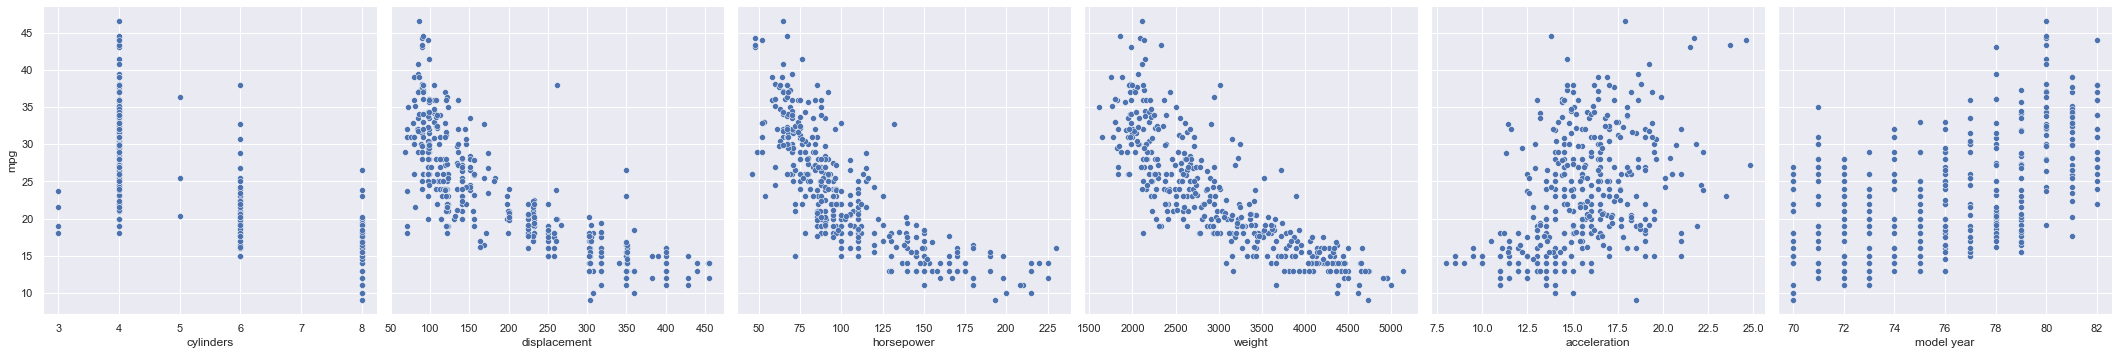

In [13]:
seaborn.pairplot(data=mpg_data, height=5,aspect=1,x_vars=x_cols, y_vars=y_cols)

## 1.3 Linear model in matrix form

Multiple linear regression 에서 입력 변수가 $d$개라고 하면 우리가 찾아야 하는 model은 다음과 같습니다. 
$$\hat{y} = w_0 + w_1x_1 + w_2x_2 + ... + w_dx_d$$
여기서 $\hat{y}$는 우리가 예측한 값입니다. 여기서 편의를 위해 $x_0=1$ 를 추가해서 위 식을 정리하면 다음과 같게 됩니다. 
$$\hat{y} = \sum_{i=0}^d w_ix_i = \mathbf{x}^\top \mathbf{w}$$
여기서 $\mathbf{x} = (x_0, x_1, ... , x_d)$로 입력 변수들로 이루어진 벡터이고  $\mathbf{w} = (w_0, w_1, ... , w_d)$로 입력 변수에 곱해지는 계수들로 이루어진 벡터입니다. 

이제 우리는 392개의 데이터를 가지고 있습니다. 이를 $N$개라고 생각하고 식을 나열해보면 다음과 같습니다. 
$$\hat{y}^{(1)} = w_0x_0^{(1)} + w_1x_1^{(1)} + w_2x_2^{(1)} + ... + w_dx_d^{(1)}$$
$$\hat{y}^{(2)} = w_0x_0^{(2)} + w_1x_1^{(2)} + w_2x_2^{(2)} + ... + w_dx_d^{(2)}$$
$$\vdots$$
$$\hat{y}^{(N)} = w_0x_0^{(N)} + w_1x_1^{(N)} + w_2x_2^{(N)} + ... + w_dx_d^{(N)}$$
이제 최종적으로 위의 식을 한번에 행렬의 형태로 표현하면 다음과 같습니다. 

$$\hat{\mathbf{y}} = \begin{bmatrix}
\hat{y}^{(1)}  \\
\hat{y}^{(2)}\\
\vdots  \\
\hat{y}^{(N)}
\end{bmatrix} =
\begin{bmatrix}
x_0^{(1)} &  x_1^{(1)} & \cdots & x_d^{(1)} \\
x_0^{(2)} &  x_1^{(2)} & \cdots & x_d^{(2)} \\
\vdots & \vdots & \ddots & \vdots \\
x_0^{(N)} &  x_1^{(N)} & \cdots & x_d^{(N)}
\end{bmatrix} \begin{bmatrix}
w_0  \\
w_1\\
\vdots  \\
w_d 
\end{bmatrix} 
= \mathbf{X}\mathbf{w}$$

여기서 $\mathbf{x}$ 는 입력 변수들을 행렬의 형태로 나타낸 것입니다. 그리고 맨 앞에 $x_0 = 1$을 추가했었기 때문에 $\mathbf{X}$의 맨 왼쪽 행렬은 1로 이루어져 있습니다. 

그리고 $\hat{\mathbf{y}}$는 예측한 변수들을 모아놓은 벡터이고, $\mathbf{y}$는 실제 연비들을 모아놓은 벡터입니다. 

In [17]:
import torch
from autograd import numpy 
from autograd import grad

ModuleNotFoundError: No module named 'torch'

## 1.4 find the weights using gradient descent 

## 1.5 Feature scaling

## 1.6 How accurate is the model?

# 2. Gradient descent land global temperature anomaly dataset